In [51]:
import pandas as pd
import evaluate
import numpy as np
import matplotlib.pyplot as plt

# from sklearn.metrics import precision_recall_fscore_support, accuracy_score, log_loss
from transformers import AutoTokenizer, DataCollatorWithPadding, DataCollatorWithPadding, DistilBertModel
from datasets import Dataset as dsDataset, DatasetDict as dsDatasetDict
from copy import deepcopy
import torch
from torch import nn
from torch import cuda
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm


In [ ]:
train_dataloader = DataLoader(
    tokenized_data["train"], batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_data["validation"], batch_size=8, collate_fn=data_collator
)

In [27]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [28]:
TRAIN_CSV = "data/train.csv"
VALID_CSV = "data/valid.csv"

PRE_TRAINED_MODEL = "distilbert-base-uncased"

SEED = 4332

MAP_DOWN = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4
}

MAP_UP = {
    0: 1,
    1: 2,
    2: 3,
    3: 4,
    4: 5
}


id2label = {0: "WORST", 1: "BAD", 2:"NEUTRAL", 3: "GOOD", 4:"EXCELLENT"}
label2id = {"WORST": 0, "BAD": 1, "NEUTRAL": 2, "GOOD": 3, "EXCELLENT": 4}


tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL)
# tokenizer = AutoTokenizer.from_pretrained("roberta-base")

accuracy = evaluate.load("accuracy")

In [29]:
def load_data(file_path):
    df = pd.read_csv(file_path)[['text','label']]
    df['label'] = df['label'].map(MAP_DOWN)
    return df.to_dict('records')

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Evaluation metric
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [33]:
train_data = load_data(TRAIN_CSV)
valid_data = load_data(VALID_CSV)

# Create a Dataset Dictionary object for hugging face's pipeline
data = dsDatasetDict({"train": dsDataset.from_list(train_data), "validation": dsDataset.from_list(valid_data)})
tokenized_data = data.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
tokenized_data = tokenized_data.remove_columns(["text"])
tokenized_data = tokenized_data.rename_column("label", "labels")
tokenized_data['train'].column_names

['labels', 'input_ids', 'attention_mask']

In [42]:
train_dataloader = DataLoader(
    tokenized_data["train"], batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_data["validation"], batch_size=8, collate_fn=data_collator
)

In [43]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 54]),
 'attention_mask': torch.Size([8, 54])}

In [80]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = DistilBERTClass()
model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [81]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 1e-05

In [82]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [83]:
# Function to calcuate the accuracy of the model
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [84]:
for _,data in enumerate(train_dataloader, 0):
    print(data.keys())
    break

dict_keys(['labels', 'input_ids', 'attention_mask'])


In [85]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(train_dataloader, 0):
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['labels'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        # if _%5000==0:
        #     loss_step = tr_loss/nb_tr_steps
        #     accu_step = (n_correct*100)/nb_tr_examples 
        #     print(f"Training Loss per 5000 steps: {loss_step}")
        #     print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    # print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    # print(f"Training Loss Epoch: {epoch_loss}")
    # print(f"Training Accuracy Epoch: {epoch_accu}")

    return epoch_loss, epoch_accu

In [86]:
def valid(model, testing_loader):
    model.eval()
    tr_loss = 0
    nb_tr_steps = 0
    n_correct = 0
    nb_tr_examples = 0
    n_wrong = 0
    total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            targets = data['labels'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            # if _%5000==0:
            #     loss_step = tr_loss/nb_tr_steps
            #     accu_step = (n_correct*100)/nb_tr_examples
            #     print(f"Validation Loss per 100 steps: {loss_step}")
            #     print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    # print(f"Validation Loss Epoch: {epoch_loss}")
    # print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_loss, epoch_accu


In [87]:
print("Start Training")
for epoch in range(EPOCHS):
    train_loss, train_acc = train(epoch)
    valid_loss, valid_acc =  valid(model, eval_dataloader)
    print(f"Epoch: {epoch + 1}/{EPOCHS}, Train Loss: {train_loss}, Train Acc: {train_acc}, Train Loss: {valid_loss}, Train Acc: {valid_acc}")

Start Training
Epoch: 0/5, Train Loss: 1.0973640181091098, Train Acc: 52.78333333333333, Train Loss: 1.0013433802127838, Train Acc: 56.25
Epoch: 1/5, Train Loss: 0.9123142030437787, Train Acc: 61.638888888888886, Train Loss: 1.0029510999917983, Train Acc: 57.2
Epoch: 2/5, Train Loss: 0.7537007702853945, Train Acc: 69.41111111111111, Train Loss: 1.0860713843107224, Train Acc: 57.4
Epoch: 3/5, Train Loss: 0.5911818536784914, Train Acc: 77.22777777777777, Train Loss: 1.222505310177803, Train Acc: 56.65
Epoch: 4/5, Train Loss: 0.44235568088458643, Train Acc: 83.93888888888888, Train Loss: 1.4387750623226165, Train Acc: 54.3


In [93]:
# Saving the files for re-use

output_model_file = 'models/pytorch_distilbert_news.pt'
output_vocab_file = 'models'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')

All files saved


# DO NOT RUN THIS

In [63]:
def get_log_type(log):
    if 'total_flos' in log.keys():
        return "NA"
    for k, _ in log.items():
        if "train" in k:
            return "train"
        if "eval" in k:
            return "eval"
        return "NA"

logs = trainer.state.log_history

train_logs = []
valid_logs =  []
other_log = []

for log in logs:
    log_type = get_log_type(log)
    if log_type == "train":
        train_logs.append(log)
        continue
    if log_type == "eval":
        valid_logs.append(log)
        continue
    other_log.append(log)
    # print("Other: ", log)

loss = [x['train_loss'] for x in train_logs]
val_loss = [x['eval_loss'] for x in valid_logs]
accuracy = [x['train_accuracy'] for x in train_logs]
val_accuracy = [x['eval_accuracy'] for x in valid_logs]
    

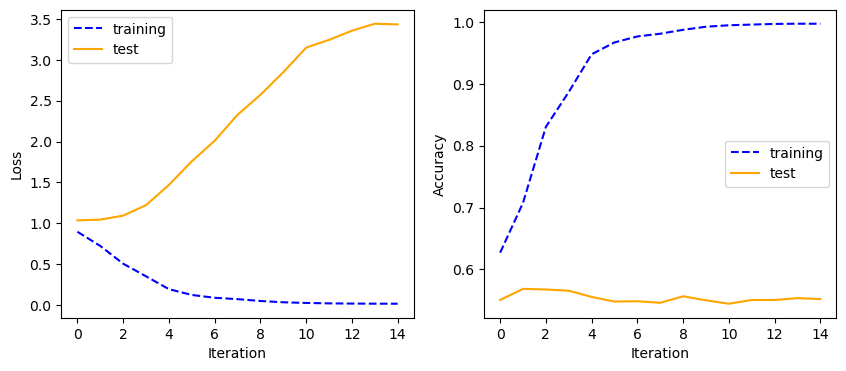

In [65]:
''' Plot loss-iteration '''
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(loss, label="training", color="blue", linestyle="dashed")
plt.plot(val_loss, label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

''' Plot accuracy-iteration '''
plt.subplot(1,2,2)
plt.plot(accuracy, label="training", color="blue", linestyle="dashed")
plt.plot(val_accuracy, label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# Inference

In [82]:
from transformers import pipeline
from tqdm import tqdm

tqdm.pandas()

TEST_CSV = "data/test_no_label.csv"
CLASSIFIER = pipeline("sentiment-analysis", model="finetune_distilbert-base-uncased")

In [83]:
testing = pd.read_csv(TEST_CSV)
testing['predict'] = testing['text'].progress_apply(CLASSIFIER)


100%|██████████| 4000/4000 [00:57<00:00, 69.21it/s]


In [88]:
def get_label_y(x):
    return x[0]['label']

testing['label'] = testing['predict'].apply(get_label_y)
testing['label'] = testing['label'].map(label2id)
testing['label'] = testing['label'].map(MAP_UP)

In [91]:
testing[['id', 'label']].to_csv("data/pred.csv")

In [132]:
test_pred = pd.read_csv(VALID_CSV)
test_pred['predict'] = test_pred['text'].progress_apply(CLASSIFIER)

100%|██████████| 2000/2000 [00:28<00:00, 71.09it/s]


In [143]:
test_pred['predict_label'] = test_pred['predict'].apply(get_label_y)
test_pred['predict_label'] = test_pred['predict_label'].map(label2id)
test_pred['predict_id'] = test_pred['predict_label'].map(MAP_UP)

In [146]:
test_pred[['id', 'predict_id']].to_csv('data/valid_pred.csv')